<a href="https://colab.research.google.com/github/cagBRT/SentimentTextAnalysis/blob/master/Text_Classification_Deep_Learning_CNN_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification - Deep Learning CNN Models

When it comes to text data, sentiment analysis is one of the most widely performed analysis on it. Sentiment Analysis has been through tremendous improvements from the days of classic methods to recent times where in the state of the art models utilize deep learning to improve the performance.

Convolutional Neural Networks or CNNs are the work-horse of the deep learning world. They have, in some sense, brought deep learning research into mainstream discussions. The advancements in the image classification world has left even humans behind.

<img src="https://github.com/dipanjanS/nlp_workshop_dhs18/blob/master/Unit%2012%20-%20Project%209%20-%20Sentiment%20Analysis%20-%20Supervised%20Learning/cnn.png?raw=1">
In this project, we will attempt at performing sentiment analysis utilizing the power of CNNs.

In [81]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Movie Review Dataset

In [4]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [84]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Prepare Train Test Split

In [85]:
# build train and test datasets
reviews = dataset['review'].values
sentiments = dataset['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# Text Wrangling & Normalization

In [86]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [87]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

  2%|▏         | 871/35000 [00:01<00:37, 902.78it/s]<ipython-input-86-6e112d5e52c8>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 15000/15000 [00:09<00:00, 1655.72it/s]

CPU times: user 33.7 s, sys: 345 ms, total: 34 s
Wall time: 46 s


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [88]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [89]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 175795), ('<PAD>', 0), 1)

In [90]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [91]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [92]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175796
Number of Documents=35000


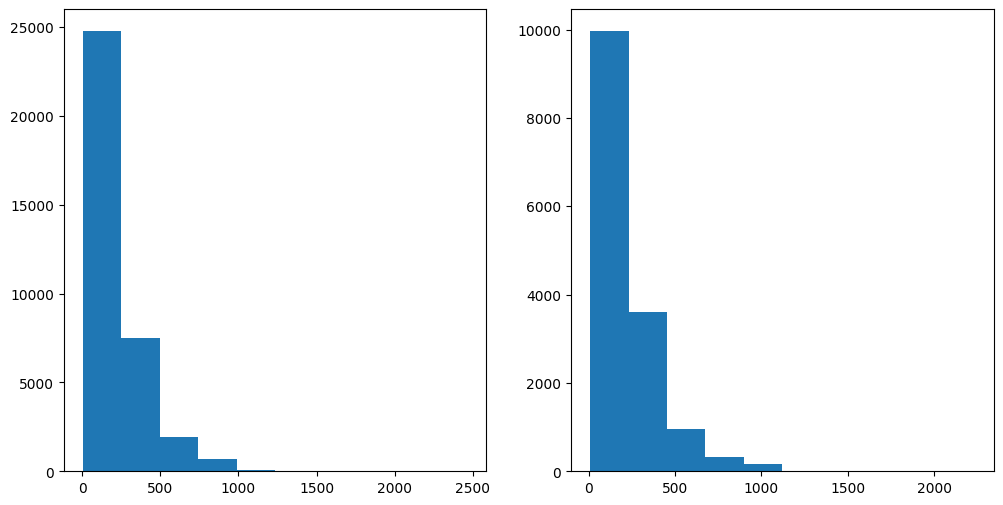

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros while longer ones are truncated

In [94]:
MAX_SEQUENCE_LENGTH = 100

In [95]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 100), (15000, 100))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [96]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [97]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [98]:
VOCAB_SIZE = len(t.word_index)

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [106]:
EMBED_SIZE = 100
EPOCHS=2
BATCH_SIZE=128

In [107]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 50)           8789800   
                                                                 
 conv1d_9 (Conv1D)           (None, 100, 128)          25728     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 50, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 50, 64)            32832     
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 25, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 25, 32)           

In [116]:
from keras import layers

In [119]:
model_yelp = Sequential()
model_yelp.add(layers.Embedding(VOCAB_SIZE,EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model_yelp.add(layers.Conv1D(128, 5, activation='relu',name="c1"))
model_yelp.add(layers.GlobalMaxPooling1D())
model_yelp.add(layers.Dense(10, activation='relu'))
model_yelp.add(layers.Dense(1, activation='sigmoid'))
model_yelp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_yelp.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 50)           8789800   
                                                                 
 c1 (Conv1D)                 (None, 96, 128)           32128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 8823229 (33.66 MB)
Trainable params: 8823229 (33.66 MB)
Non-trainable params: 0 (0.00 Byte)
______________

## Model Training

In [124]:
# Fit the model
model_yelp.fit(X_train, y_train,
          validation_split=0.1,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1)

Epoch 1/2
247/247 [==============================] - 43s 153ms/step - loss: 0.5228 - accuracy: 0.7256 - val_loss: 0.3609 - val_accuracy: 0.8414
Epoch 2/2
247/247 [==============================] - 16s 66ms/step - loss: 0.2602 - accuracy: 0.8931 - val_loss: 0.3306 - val_accuracy: 0.8557


## Model Evaluation

In [125]:
# Final evaluation of the model
scores = model_yelp.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 2s 4ms/step - loss: 0.3270 - accuracy: 0.8576
Accuracy: 85.76%


In [126]:
predictions = model_yelp.predict(X_test).ravel()
predictions[:10]

469/469 [==============================] - 1s 2ms/step


array([0.04569295, 0.9693979 , 0.01972459, 0.97135   , 0.96475863,
       0.02756532, 0.9291835 , 0.38031238, 0.6655747 , 0.9497524 ],
      dtype=float32)

In [127]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]
dataset.head()

for i in range(10):
  print(predictions[i],test_sentiments[i],"::",test_reviews[i])

negative negative :: Just don't bother. I thought I would see a movie with great supspense and action.<br /><br />But it grows boring and terribly predictable after the interesting start. In the middle of the film you have a little social drama and all tension is lost because it slows down the speed. Towards the end the it gets better but not really great. I think the director took this movie just too serious. In such a kind of a movie even if u don't care about the plot at least you want some nice action. I nearly dozed off in the middle/main part of it. Rating 3/10.<br /><br />derboiler.
negative positive :: Be careful with this one. Once you get yer mitts on it, it'll change the way you look at kung-fu flicks. You will be yearning a plot from all of the kung-fu films now, you will be wanting character depth and development, you will be craving mystery and unpredictability, you will demand dynamic camera work and incredible backdrops. Sadly, you won't find all of these aspects togeth

In [128]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.50      1.00      0.67      7490
    positive       0.00      0.00      0.00      7510

    accuracy                           0.50     15000
   macro avg       0.25      0.50      0.33     15000
weighted avg       0.25      0.50      0.33     15000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,negative,positive
negative,7490,0
positive,7510,0
